# COMP 671D: Homework 3
## Author: Samuel Eure
## Problem 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.optimize import minimize
import random
from sklearn import metrics

In [2]:
train     = pd.read_csv("house_votes_84_train.csv", sep = ',')
test      = pd.read_csv("house_votes_84_test.csv", sep = ',')
samples   = len(train.iloc[:,0])

In [3]:
def getJandError(train,d):
    j_t = -1
    minError = 2.0
    realY = np.array(train.iloc[:,0])
    for j in range(len(train.iloc[0,1:])):
        j += 1
        predictions = np.array(train.iloc[:,j])
        score = np.matmul((predictions != realY),d)
        if score < minError:
            minError = score
            j_t = j
    return(j_t, minError)

## Problem 3a

### AdaBoost Implementation

In [4]:
T = len(train.iloc[0,1:])
realY = np.array(train.iloc[:,0])
d = np.ones(samples)/samples
weights = np.zeros(T)
for t in range(100):    # I run the algorithm 100 times however my weights 
                      #   essentially converge after the first iteration
    
    j_t, error = getJandError(train,d)
    
    alpha = 0.5*np.log((1-error)/error)
    weights[j_t-1] += alpha
    predictions = np.array(train.iloc[:,j_t])
    correct   = (predictions == realY)*np.exp(-1*alpha)
    incorrect = (predictions != realY)*np.exp(alpha)
    d = correct + incorrect
    d = d/sum(d)

features = np.array(train.iloc[:, 1:])

### Adaboost Model Evaluation

In [5]:
print("Training Accuracy:",np.mean(np.sign(np.matmul(
    np.array(train.iloc[:,1:]),weights))==realY)) #Accuracy
print("Test Accuracy:",np.mean(np.sign(np.matmul(
    np.array(test.iloc[:,1:]),weights))==np.array(test.iloc[:,0]))) #Accuracy  

Training Accuracy: 0.9428571428571428
Test Accuracy: 0.98


## Problem 3b

### Logistic Regression Implementation

#### For this problem, I will find the minimum of the negative log likelihood instead of the maximium log likelihood. This will accomplish the same thing.

#### Given that:

$-log(P(Y_i = y_i | \vec \beta, \vec x_i)) = log(1+e^{-y_i \vec \beta\cdot \vec x_i})$,

#### the negative log likelihood of $-log(L(\beta))$ is equal to $-log(L(\beta)) = \sum_{i=1}^n log(1+e^{-y_i \vec \beta\cdot \vec x_i})$.

#### This function will be minimized with respect to $\beta$


In [6]:
def getNLL(betas):
    data = np.array(train)
    prod = np.matmul(data[:, 1:], betas) #features
    yValues = np.array(data[:, 0]) #real y values
    yProd   = yValues*prod
    return(np.sum(np.log(1+np.exp( -1*yProd))))

betas0 = np.zeros(T) 
getNLL(betas0)   #Algorithm Testing

266.8616645155789

### Determining "optimal" beta values

In [7]:
results = scipy.optimize.minimize(getNLL, x0 = np.zeros(T))
optimalBetas = results.x
print("Optimal Beta Values:", optimalBetas)

Optimal Beta Values: [ 0.07097047 -0.77902062 -1.34247057  4.29392102  1.78724924 -2.19311427
  1.7240725  -0.75573081 -1.05317142  1.4752639  -1.43506075  1.08354749
 -0.32326115 -0.76060663 -0.29633747 -0.83586897]


### Model Evaluation for Logistic Regression

In [8]:
def evaluateBetas(data, optimalBetas):
    data = np.array(data)
    y = data[:, 0]
    X = data[:, 1:]
    BX = np.matmul(X, optimalBetas)
    
    probYis1 = 1/(1+ np.exp(-1*BX))
    prePreds    = probYis1 >= 0.5
    predictions = prePreds*2 -1
    fpr,tpr, thresholds = metrics.roc_curve(y,predictions, pos_label=1)
    print("AUC:", np.round(metrics.auc(fpr, tpr),4))
    acc = np.mean((predictions == y))
    print("Accuracy:", 100*np.round(acc,4), "%")
    return()
    
    
    
print("For the training  data set:")
evaluateBetas(train, optimalBetas)
print("------------------------")
print("For the test data set:")
evaluateBetas(test, optimalBetas)

For the training  data set:
AUC: 0.9677
Accuracy: 96.36 %
------------------------
For the test data set:
AUC: 0.9228
Accuracy: 94.0 %


()

## Problem 3c

### Model Comparison

#### In this problem, I will compare the test accuracies, ROC Curves/AUC Values, and F1 acores.

In [9]:
test = np.array(test)
y = test[:, 0]
X = test[:, 1:]

# Logistic Regression Data
BX = np.matmul(X, optimalBetas)
LR_probs = 1/(1+ np.exp(-1*BX))
LR_predictions = (LR_probs >= 0.5)*2 -1

# AdaBoost Data
AD_rawScores   = np.matmul(np.array(X),weights) #Used for ROC curve
AD_predictions = np.sign(AD_rawScores)

In [10]:
def getROC(name, probabilities):
    fpr, tpr, thresh = metrics.roc_curve(y,probabilities , pos_label = 1)
    auc = np.round(metrics.auc(fpr, tpr),4)

    plt.plot(fpr, tpr)
    plt.title("ROC Curve for " + name +  " (AUC: "+str(auc)+")", fontsize = 15)
    plt.plot([0,1],[0,1], 
             color = 'black', 
             alpha = .5, 
             linestyle = 'dashed')
    plt.xlabel("FPR", fontsize = 15)
    plt.ylabel("TPR", fontsize = 15)
    
def getAcc_F1(predictions, y):
    TotPos = sum(y == 1)
    TotNeg = len(y) - TotPos
    
    correct = (predictions == y)
    PredPos = (predictions == 1)
    
    TP = sum(PredPos*correct)
    recall = TP/TotPos
    precision = TP/sum(PredPos)
    F1 = 2*((precision*recall)/(precision+recall))
    print("Accuracy: ",np.mean(correct))
    print('Recall:   ',recall)
    print("Precision:", np.round(precision,4))
    print("F1 Score: ", np.round(F1,4)) 

Accuracy:  0.94
Recall:    0.875
Precision: 0.9333
F1 Score:  0.9032


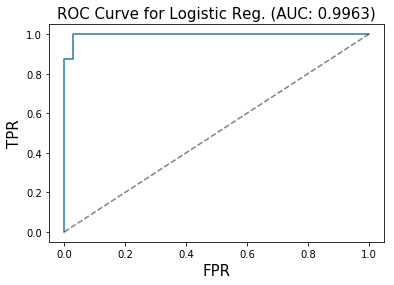

In [11]:
#Logistic Regression 
getROC('Logistic Reg.', LR_probs)
getAcc_F1(LR_predictions,y)

Accuracy:  0.98
Recall:    1.0
Precision: 0.9412
F1 Score:  0.9697


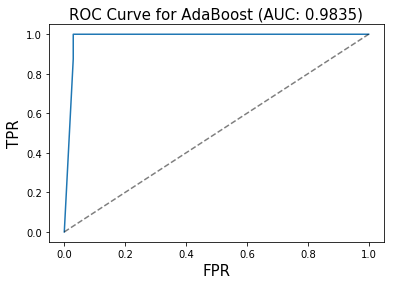

In [12]:
#AdaBoost
getROC('AdaBoost',AD_rawScores)
getAcc_F1(AD_predictions,y)

### Comments on the models

#### It appears that the Adaboost algorithm obtained a higher accuracy, recall, precision, and F1 score than the Logistic Regression algorithm. This suggests that the Adaboost algorithm does a better job in classification than the logistic regression algorithm for this data set and given the specifications of the problem. However, it should be noted that the Logistic Regression algorithm obtained a higher area under the ROC curve (i.e. AUC score) than the Adaboost algorithm, althoughly only slighly (about a 0.0128 difference).

#### In summary, the Adaboost algorithm seemed to perform better than the logistic regression algorithm, however both  models did decently well in the classification problem given that they both have accuracies in the mid to high nineties. 

## Problem 3d

#### During each iteration of the AdaBoost algorithm one of sixteen classifiers was chosen and coordinate gradient decent was performed in the direction of that classifiers. Given that the algorithm chooses between 16 weak classifiers at each step, the weight vector for the AdaBoost implementation for this data set is 16 dimentional, with the $i^{th}$ dimention being attributed to the $i^{th}$ weak classifier, which is related to the $i^{th}$ bill. Thus, the AdaBoost algorithm would suggest that those classifiers with large weights are "important" for making predictions. Thus the most important bills for making predictions from the view of the Adaboost algorithm are...

Text(0, 0.5, 'Weight')

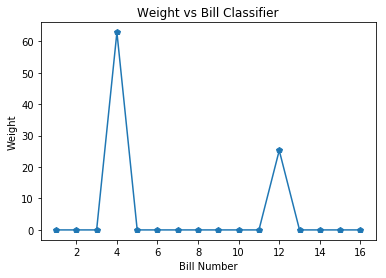

In [13]:
bills = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.plot(bills,weights, '-p')
plt.title("Weight vs Bill Classifier")
plt.xlabel("Bill Number")
plt.ylabel("Weight")

#### Bills 4 and 12 are the most significant predictors given that they're the only bills with nonzero weights attribute to them. Indeed, Adaboost has determined that given these two variable, the remaining 14 varaibles are essentially superfulous. Furthermore, it apppears that even when the 12th bill is removed as a predictor, the Adaboost algorithm is able to produce the same accuracy as it was able to with all the predictors, so Bill 12 doesn't seem that important in terms of predictions in comparision to Bill 4. This is shown below:

In [14]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)
print("Original Training Accuracy:",np.mean(np.sign(np.matmul(
    np.array(test.iloc[:,1:]),weights))==np.array(test.iloc[:,0]))) #Accuracy  
remember12 = np.array(train.iloc[:, 12])
train.iloc[:, 12] = 1 #rendering it useless
T = len(train.iloc[0,1:])
realY = np.array(train.iloc[:,0])
d = np.ones(samples)/samples
weights = np.zeros(T)
for t in range(100):    # I run the algorithm 100 times however my weights 
                      #   essentially converge after the first iteration
    
    j_t, error = getJandError(train,d)
    
    alpha = 0.5*np.log((1-error)/error)
    weights[j_t-1] += alpha
    predictions = np.array(train.iloc[:,j_t])
    correct   = (predictions == realY)*np.exp(-1*alpha)
    incorrect = (predictions != realY)*np.exp(alpha)
    d = correct + incorrect
    d = d/sum(d)

print("Test Accuracy when 12 is removed:",np.mean(np.sign(np.matmul(
    np.array(test.iloc[:,1:]),weights))==np.array(test.iloc[:,0]))) #Accuracy  

train.iloc[:, 12] = pd.DataFrame(remember12)
remember4  = np.array(train.iloc[:,4])
train.iloc[:,4]   = 1
d = np.ones(samples)/samples
weights = np.zeros(T)
for t in range(100):    # I run the algorithm 100 times however my weights 
                      #   essentially converge after the first iteration
    
    j_t, error = getJandError(train,d)
    
    alpha = 0.5*np.log((1-error)/error)
    weights[j_t-1] += alpha
    predictions = np.array(train.iloc[:,j_t])
    correct   = (predictions == realY)*np.exp(-1*alpha)
    incorrect = (predictions != realY)*np.exp(alpha)
    d = correct + incorrect
    d = d/sum(d)

print("Test Accuracy when 4 is removed:",np.mean(np.sign(np.matmul(
    np.array(test.iloc[:,1:]),weights))==np.array(test.iloc[:,0]))) #Accuracy 
train.iloc[:,4] = pd.DataFrame(remember4)

Original Training Accuracy: 0.98
Test Accuracy when 12 is removed: 0.98
Test Accuracy when 4 is removed: 0.86


#### This suggests that Bill 4 is the most significant predictor of partisan ship from an Adaboost perspective, however, in it's absence, Adaboost is still able to obtain an 0.86 accuracy, suggesting that some of the remaining bills contain predictive power of their own. 

#### From the standpoint of logistic regression, it would appear that bills with large corresponding beta values would be important predictors of partisianship. Let us look at the which beta values are largest:

Text(0, 0.5, 'Beta Value')

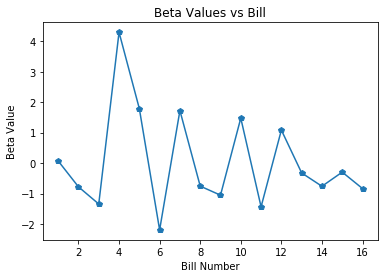

In [15]:
plt.plot(bills,optimalBetas, '-p')
plt.title("Beta Values vs Bill")
plt.xlabel("Bill Number")
plt.ylabel("Beta Value")

#### If the magnitude of the beta value was attributed to the importance of the predictions, it would appear that bills number 4, 5, 7, 10, and 12 are the most important. To test this hypothesis, I will "remove" the information stored in each of these bills by setting their values equal to 1 for each observation, and then run my logistic regression algorithm on this new data set for each of the features:

In [16]:
print("Original Data Set")
evaluateBetas(test, optimalBetas)
print("_________________________________")
for b in bills:
    removedBill = np.array(train.iloc[:, b])
    train.iloc[:,b] = 1 #rendering the bill useless
    results = scipy.optimize.minimize(getNLL, x0 = np.zeros(T))
    optimalBetas = results.x
    print("Accuracy and AUC when bill",str(b), "is removed:")
    evaluateBetas(test, optimalBetas)
    train.iloc[:,b] = pd.DataFrame(removedBill)
    print("_________________________________")

Original Data Set
AUC: 0.9228
Accuracy: 94.0 %
_________________________________
Accuracy and AUC when bill 1 is removed:
AUC: 0.9081
Accuracy: 92.0 %
_________________________________
Accuracy and AUC when bill 2 is removed:
AUC: 0.8327
Accuracy: 84.0 %
_________________________________
Accuracy and AUC when bill 3 is removed:
AUC: 0.9393
Accuracy: 94.0 %
_________________________________
Accuracy and AUC when bill 4 is removed:
AUC: 0.7574
Accuracy: 76.0 %
_________________________________
Accuracy and AUC when bill 5 is removed:
AUC: 0.8934
Accuracy: 90.0 %
_________________________________
Accuracy and AUC when bill 6 is removed:
AUC: 0.8768
Accuracy: 90.0 %
_________________________________
Accuracy and AUC when bill 7 is removed:
AUC: 0.9853
Accuracy: 98.0 %
_________________________________
Accuracy and AUC when bill 8 is removed:
AUC: 0.9393
Accuracy: 94.0 %
_________________________________
Accuracy and AUC when bill 9 is removed:
AUC: 0.954
Accuracy: 96.0 %
__________________

#### These results suggest that removing features 4 dramatically reduces the test accuracy and removing feature 2 someone significantly reduces the test accuracy. This would suggest that each of these bills are important for predictions in general. Another interesting discovery of these calculations is that the removal of bills 7,9, and 10 actually leads to an INCREASE in test accuracy. This is most likely due to overfitting of the training data when using all bills are predictors. 